# Week 15

In [141]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from scipy.spatial import Delaunay
from scipy.optimize import minimize

from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_adjacent_vertices_with_boundary_vertex, retrieve_adjacent_vertices_with_vertex, retrieve_boundary_edges_related_vertices_2D
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_boundary_vertices
from util.mesh.triangle.algorithm.R2.mapping_poly_square import Liu_2017
from util.util import distance_euclidean

from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_boundary_vertices_related_edges_2D, retrieve_boundary_edges_related_vertices_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.mesh.triangle.algorithm.R2.my_test import boundary_smoothing_tutte

from util.pyvista_util import preprocess, postprocess

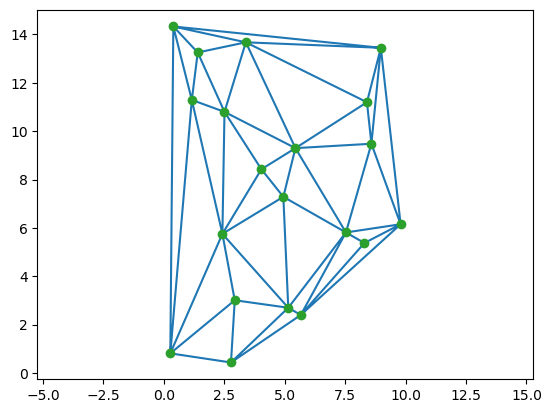

In [262]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=10
points[:, 1]*=15

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

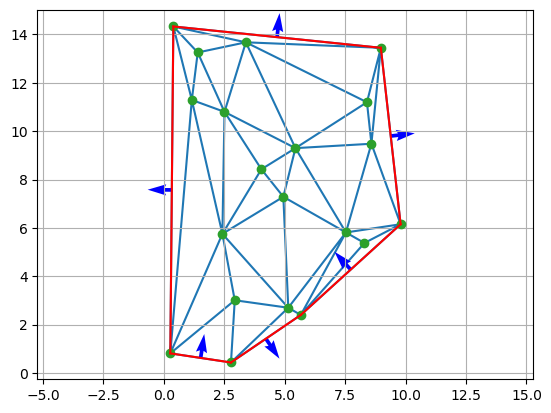

In [263]:
# edges = triangle_edges(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

plt.axis('equal')
plt.grid() 
plt.show()


In [252]:
class Chen_2023_scipy:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
        self.lambda_ = np.ones(self.BV_num)*0.1
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return 0
        
    def objective(self, BV):
        lambda_ = BV[2*self.BV_num:]
        BV = BV[:2*self.BV_num].reshape((self.BV_num,2))
                
#         print(BV, lambda_)

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            # 倒数障碍函数
            E_angle += -lambda_[i] / np.power((np.dot(edge1, edge2)), 1)
            # Log障碍函数
#             E_angle += -lambda_[i]*(-np.log(np.dot(edge1, edge2)))
            
            # 自己设计的障碍函数
#             if cos_theta > 0:
# #                 E_angle += -lambda_[i]*(-np.log(np.dot(edge1, edge2)))
# #                   E_angle += -lambda_[i] / (np.dot(edge1, edge2))
#                 angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
#                 E_angle += self.activation(angle)
            
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)
#         print(E_align, E_angle)

        return  E_align+self.lambda1*E_angle
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(self.vertices, self.faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        
        x0 = np.ravel(self.solution[self.BV_r_V])
        x0_lambda = np.hstack((x0, self.lambda_))
        print(x0_lambda)
        self.res = minimize(self.objective, x0_lambda, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.lambda_ = self.res.x[2*self.BV_num:]
        self.solution[self.BV_r_V] = self.res.x[:2*self.BV_num].reshape((len(self.BV_r_V) , 2))
        
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        x0_lambda = np.hstack((x0, self.lambda_))
        self.res = minimize(self.objective, x0_lambda, options = {'maxiter': 1}, method = "BFGS")
        self.lambda_ = self.res.x[2*self.BV_num:]
        self.solution[self.BV_r_V] = self.res.x[:2*self.BV_num].reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [248]:
cat_v, cat_f = preprocess("./mesh/cat/cat_input.ply")
cat_test = Chen_2023_scipy(cat_v, cat_f, lambda1=1)

In [249]:
cat_test.optimize(1)

Round  0  done!


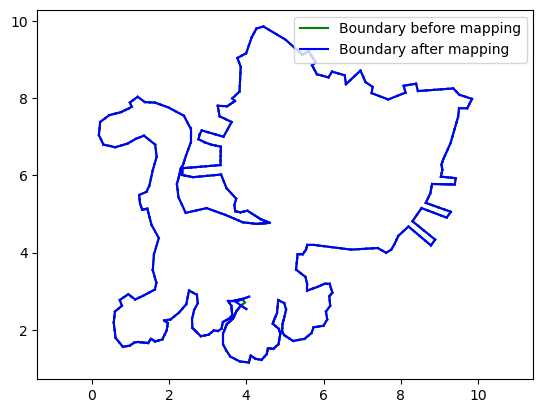

In [284]:
cat_test.v_plt(show_origin=True, show_BV=False, show_vertices=False, show_inner_edges=False)

# ============================================================

In [270]:
test = Chen_2023_scipy(points.copy(), tri.simplices, max_iter = 100)

In [271]:
test.optimize_default()

[ 5.66550354  2.39835318  0.26976149  0.8099887   0.3940766  14.33022171
  8.97682302 13.44791248  9.79455972  6.15046195  2.77820055  0.43312988
  0.1         0.1         0.1         0.1         0.1         0.1       ]


In [272]:
test.lambda_

array([ 0.00903394,  0.14775262,  0.26664377,  0.40501417,  0.0427841 ,
       -0.12448025])

In [273]:
# test.optimize(30)

In [274]:
test.res

      fun: 5.445907939208638
 hess_inv: array([[ 1.18631983e+00,  5.67625792e-02, -4.34936018e-02,
         2.06651365e-01,  6.25045925e-02,  1.01451338e-03,
        -1.76064401e-01, -4.12159066e-03, -1.50829723e-01,
        -3.22203266e-01,  1.21563291e-01,  6.18963344e-02,
        -3.54570036e-02,  3.27458501e-02,  7.31908141e-02,
         1.33598364e-01, -2.04318038e-02, -8.03333511e-02],
       [ 5.67625792e-02,  3.82938220e-01, -7.63903056e-03,
         2.69773487e-01,  1.45121807e-02,  6.74557922e-04,
        -4.11726765e-02, -1.01148120e-04, -1.81383033e-02,
        -3.28510506e-02, -4.32438007e-03,  3.79566423e-01,
        -9.21739148e-03,  3.39435183e-02,  1.36898579e-02,
        -2.03361878e-02, -2.30868166e-03, -8.70044337e-03],
       [-4.34936018e-02, -7.63903056e-03,  5.14087505e-01,
         3.72657457e-03,  4.76267045e-01, -9.54558400e-04,
         3.96360610e-02,  6.70220924e-04,  5.59262679e-03,
         1.37054189e-02,  7.90997157e-03, -9.50909801e-03,
         9.235

In [275]:
test.mapping()

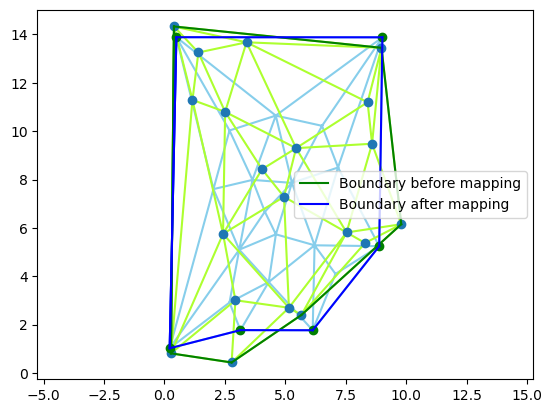

In [276]:
test.v_plt(show_vertices=True, show_origin=True, show_BV=True, show_inner_edges=True)

In [71]:
ttt = test.optimize_one_round()

[ 9.67237514  1.95242904  0.30979222 13.82731239  4.97958795 14.51900114
  0.84524813  3.10469939  9.90436243  2.94331584  5.967539    0.32470607
  9.75755558  7.56963871  0.1         0.1         0.1         0.1
  0.1         0.1         0.1       ]


In [65]:
ttt

array([ 9.67237514,  1.95242904,  0.30979222, 13.82731239,  4.97958795,
       14.51900114,  0.84524813,  3.10469939,  9.90436243,  2.94331584,
        5.967539  ,  0.32470607,  9.75755558,  7.56963871,  0.1       ,
        0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
        0.1       ])

In [66]:
ttt.shape

(21,)

In [67]:
ttt[2*test.BV_num:]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [68]:
test.objective(ttt)

[[ 9.67237514  1.95242904]
 [ 0.30979222 13.82731239]
 [ 4.97958795 14.51900114]
 [ 0.84524813  3.10469939]
 [ 9.90436243  2.94331584]
 [ 5.967539    0.32470607]
 [ 9.75755558  7.56963871]] [0.1 0.1 0.1 0.1 0.1 0.1 0.1]


14.681020494089598

$$
min f(V) = V_2 + V_3 - 2*V_1 + ||V_2 - V_1||_1 + ||V_3 - V_1||_1 \\
s.t. \cos(\theta) < 0 \\
cos(\theta) = \frac{(V_2 - V_1)\dot(V_3-V_1)}{||V_2 - V_1||_2||V_3 - V_1||_2}
$$

要求函数 \( f(V) \) 对 \( V_1 \) 的偏导数，我们首先需要考虑绝对值函数的导数。绝对值函数的导数依赖于其内部的值：

$$\frac{d}{dx} |x| = \begin{cases} 
1, & \text{if } x > 0 \\
-1, & \text{if } x < 0 \\
\text{undefined}, & \text{if } x = 0 
\end{cases} $$

现在考虑 \( f(V) \) 中涉及 \( V_1 \) 的项，有：

$$ -2V_1 + |V_2 - V_1| + |V_3 - V_1| $$

我们可以分别考虑 \( V_2 - V_1 \) 和 \( V_3 - V_1 \) 的符号来求偏导数。

1. 对于 \( |V_2 - V_1| \)：

偏导数是：

$$ \frac{\partial}{\partial V_1} |V_2 - V_1| = \begin{cases} 
-1, & \text{if } V_2 > V_1 \\
1, & \text{if } V_2 < V_1 \\
\text{undefined}, & \text{if } V_2 = V_1 
\end{cases} $$

2. 对于 \( |V_3 - V_1| \)：

偏导数是：

$$ \frac{\partial}{\partial V_1} |V_3 - V_1| = \begin{cases} 
-1, & \text{if } V_3 > V_1 \\
1, & \text{if } V_3 < V_1 \\
\text{undefined}, & \text{if } V_3 = V_1 
\end{cases} $$

现在，我们可以组合所有这些项来得到 \( f(V) \) 对 \( V_1 \) 的偏导数：

$$ \frac{\partial f(V)}{\partial V_1} = -2 + \frac{\partial}{\partial V_1} |V_2 - V_1| + \frac{\partial}{\partial V_1} |V_3 - V_1| $$

根据之前的分析，这个偏导数的值会依赖于 \( V_1, V_2, \) 和 \( V_3 \) 之间的相对大小。

如果你的初值选择的时候 \( \cos(\theta) > 0 \)，那么倒数障碍函数 \( B(V) \) 在这个初值下的值会变得很大。具体来说，对于约束 \( \cos(\theta) < 0 \)，我们的倒数障碍函数为：

$$ B(V) = \frac{-\mu}{(V_2 - V_1) \cdot (V_3-V_1) - \lVert V_2 - V_1 \rVert_2 \lVert V_3 - V_1 \rVert_2} $$

对于 \( \cos(\theta) > 0 \)，分母是正数，所以整个障碍函数是负值，且由于倒数的形式，其绝对值会很大。这就意味着，开始的目标函数值 \( F(V) = f(V) + B(V) \) 会受到很大的惩罚。

优化算法的目标是最小化 \( F(V) \)。由于障碍函数部分对整体函数值有显著的贡献，算法将会被驱使往满足约束 \( \cos(\theta) < 0 \) 的方向移动。

所以，答案是：是的，如果你使用了适当的优化算法和参数设置，迭代过程将朝着 \( \cos(\theta) < 0 \) 的方向收敛，即使初始值是 \( \cos(\theta) > 0 \)。但要注意，算法的收敛性和速度会依赖于其他因素，如初始点的选择、障碍函数参数 \( \mu \) 的设置、以及所使用的优化算法的性质。

In [277]:
def compute_star_points(R):
    outer_radians = np.deg2rad(72 * np.arange(5))
    outer_x = R * np.cos(outer_radians)
    outer_y = R * np.sin(outer_radians)
    outer_points = np.column_stack((outer_x, outer_y))
    
    r = R * np.sin(np.deg2rad(18)) / np.sin(np.deg2rad(36))
    
    inner_radians = np.deg2rad(72 * np.arange(5) + 36)
    inner_x = r * np.cos(inner_radians)
    inner_y = r * np.sin(inner_radians)
    inner_points = np.column_stack((inner_x, inner_y))
    
    inner_tri= Delaunay(inner_points)
    faces = inner_tri.simplices
    vertices = np.vstack((inner_points, outer_points))    
    face_temp = np.array([[4,5,0],[0,6,1],[1,7,2],[2,8,3],[3,9,4]])
    faces = np.vstack((faces, face_temp))
    
    return vertices, faces

In [278]:
R = 1
vertices, faces = compute_star_points(R)

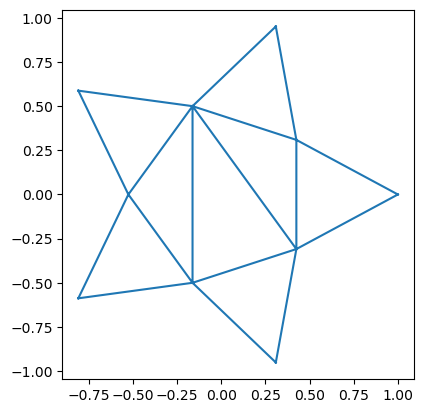

In [279]:
plt.triplot(vertices[:,0], vertices[:,1], faces)
plt.gca().set_aspect('equal')
plt.show()

In [280]:
star = Chen_2023_scipy(vertices, faces, max_iter = 20, lambda1=10)

In [281]:
star.optimize_default()

[ 4.25325404e-01  3.09016994e-01 -1.62459848e-01  5.00000000e-01
 -5.25731112e-01  6.43834924e-17 -1.62459848e-01 -5.00000000e-01
  4.25325404e-01 -3.09016994e-01  1.00000000e+00  0.00000000e+00
  3.09016994e-01  9.51056516e-01 -8.09016994e-01  5.87785252e-01
 -8.09016994e-01 -5.87785252e-01  3.09016994e-01 -9.51056516e-01
  1.00000000e-01  1.00000000e-01  1.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01  1.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01]


In [282]:
star.res

      fun: 1.1825638469349737
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 

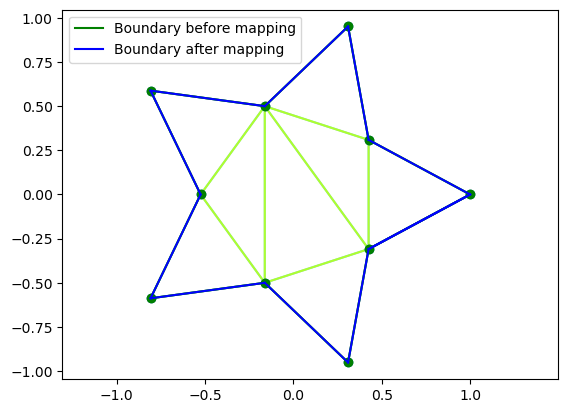

In [283]:
star.v_plt(show_vertices=True, show_origin=True, show_BV=True, show_inner_edges=True)